In [7]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern, RationalQuadratic
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error

#add other feature that can contribute to the emissions forecast such as economic indicator, and population, and vehicles miles travelled data. 

# Load your data
data = pd.read_excel('../../../data/raw/Public GHG data 1990-2021.xlsx', sheet_name="Emission Totals")
vmt_Ct = pd.read_csv('../../../data/tidy/vmt-CT.csv')


data

,Sector Emissions (MMTCO2e),1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2016,2017,2018,2019,2020,2021 (ESTIMATE),2021 % of Total Emissions,% change from 1990,% change from last year,% change from 2001
0,Agriculture,0.375261,0.348502,0.389088,0.415000,0.408122,0.400748,0.344938,0.348057,0.375380,...,0.339883,0.341291,0.350344,0.369979,0.346028,0.350000,0.010075,-0.067316,0.011480,-0.062704
1,Natural Gas Leakage,0.794155,0.762277,0.747679,0.720340,0.695204,0.668485,0.638662,0.614303,0.588198,...,0.245919,0.243363,0.240438,0.241217,0.240000,0.240000,0.006909,-0.697792,0.000000,-0.532010
2,Commercial,3.828568,3.662331,4.312955,3.843474,4.172272,3.841800,4.133427,4.301810,4.036593,...,3.907677,3.920870,4.329612,4.196598,3.824505,4.001450,0.115189,0.045156,0.046266,-0.073598
3,Commercial (CO2FFC),3.802622,3.636449,4.283215,3.814070,4.142831,3.813977,4.103763,4.273123,4.010713,...,3.885436,3.898378,4.306234,4.173702,3.803173,3.979450,0.114555,0.046502,0.046350,-0.072990
4,Commercial (Stationary),0.025946,0.025882,0.029740,0.029404,0.029441,0.027823,0.029664,0.028687,0.025880,...,0.022242,0.022492,0.023378,0.022896,0.021332,0.022000,0.000633,-0.152093,0.031333,-0.171856
5,Electric Power (Consumption),11.908703,12.015808,11.282676,10.228667,10.395885,10.320433,10.734700,13.201970,12.948870,...,9.289161,8.501146,8.066976,5.690000,3.200000,3.040000,0.087512,-0.744725,-0.050000,-0.753715
6,Electric Power (Generation),12.125818,11.775872,9.771757,8.650563,8.513378,9.737109,11.311067,14.507413,13.348240,...,8.574717,7.866282,9.589895,9.523774,10.206000,10.955000,0.315358,-0.096556,0.073388,-0.040398
7,CO2 (EIA State Energy Profile),12.084447,11.736217,9.738805,8.621568,8.485521,9.707468,11.276329,14.462553,13.308563,...,8.558718,7.854365,9.574281,9.510000,10.186000,10.940000,0.314926,-0.094704,0.074023,-0.038865
8,CH4 and N2O (Stationary),0.041371,0.039655,0.032952,0.028995,0.027857,0.029641,0.034738,0.044860,0.039677,...,0.015998,0.011917,0.015615,0.013774,0.020000,0.015000,0.000432,-0.637431,-0.250000,-0.556474
9,Industrial,3.001041,3.100758,3.355918,3.447719,3.150548,3.103303,3.257568,3.266450,3.119599,...,3.152446,3.123419,3.137983,3.146549,3.128899,3.376378,0.097195,0.125069,0.079094,0.011279


In [8]:
selected_columns = data.iloc[16, 1:33]
selected_columns

1990               15.120625
1991               15.005884
1992               15.086747
1993               15.146864
1994               15.066461
1995               14.815692
1996               15.623592
1997                15.67985
1998               15.917011
1999               17.112669
2000               16.658678
2001               17.301097
2002               17.195188
2003               17.921412
2004               19.535977
2005               18.506215
2006               17.733149
2007               17.626947
2008               16.587534
2009               16.224746
2010               16.038716
2011               15.745639
2012               15.308146
2013               15.060186
2014               15.016348
2015               15.087477
2016                15.21436
2017               15.325243
2018                15.63322
2019               15.399656
2020               13.071437
2021 (ESTIMATE)    14.766522
Name: 16, dtype: object

In [9]:
#define a set of candidate kernel: radial basis function, matern kernel, rational quadratic, exponential kernel
#implement a model selection strategy: using cross-validation to evaluate the performance of each kernel on your dataset; leave-one-out cross validation for the limited dataset
#optimize hyperparameters: for each kernel, optimize its hyperparameters using maximu likelihood estimate or other optimization methods
#compare the 

Kernel: 1**2 * RBF(length_scale=1), Log-Marginal Likelihood: -26.691147396975378
Kernel: 1**2 * Matern(length_scale=1, nu=1.5), Log-Marginal Likelihood: -27.216737329787218


C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Kernel: 1**2 * RationalQuadratic(alpha=0.1, length_scale=1), Log-Marginal Likelihood: -26.691154973908205
Kernel: 1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1), Log-Marginal Likelihood: -26.710121680252875
Kernel: 1**2 * RBF(length_scale=1) + ExpSineSquared(length_scale=1, periodicity=10), Log-Marginal Likelihood: -26.691148286128687


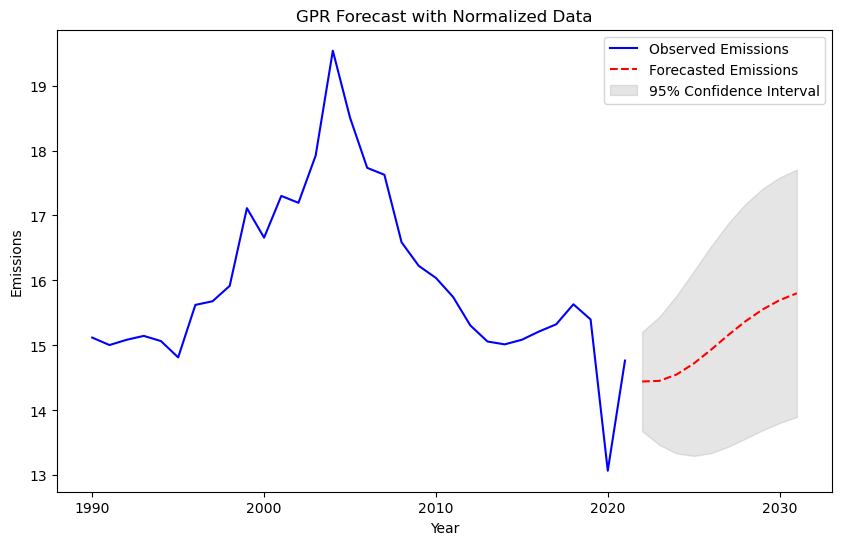

In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, DotProduct, ConstantKernel as C, ExpSineSquared
import matplotlib.pyplot as plt

# Sample data
data = {
    'Year': np.arange(1990, 2022),
    'Emissions': [
        15.120625, 15.005884, 15.086747, 15.146864, 15.066461,
        14.815692, 15.623592, 15.67985, 15.917011, 17.112669,
        16.658678, 17.301097, 17.195188, 17.921412, 19.535977,
        18.506215, 17.733149, 17.626947, 16.587534, 16.224746,
        16.038716, 15.745639, 15.308146, 15.060186, 15.016348,
        15.087477, 15.21436, 15.325243, 15.63322, 15.399656,
        13.071437, 14.766522
    ]
}

df = pd.DataFrame(data)
selected_columns = df[['Year']]  # Ensure this is a DataFrame
y = df['Emissions'].values  # This is a 1D array

from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, DotProduct, ConstantKernel as C, ExpSineSquared
import numpy as np
import matplotlib.pyplot as plt

# Assume selected_columns and y are already defined properly
# selected_columns should be a 1D series or DataFrame column
# y should be a 1D array or series

# Normalize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Reshape selected_columns to be 2D
X_scaled = scaler_X.fit_transform(selected_columns.values.reshape(-1, 1))
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()

# Define kernels
kernels = [
    C(1.0, (1e-2, 1e2)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)),
    C(1.0, (1e-2, 1e2)) * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=1.5),
    C(1.0, (1e-2, 1e2)) * RationalQuadratic(length_scale=1.0, alpha=0.1),
    C(1.0, (1e-2, 1e2)) * DotProduct(sigma_0=1.0) + RBF(length_scale=1.0),
    C(1.0, (1e-2, 1e2)) * (RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) +
                            ExpSineSquared(length_scale=1.0, periodicity=10))
]

# Train GPR models with normalized data
best_score = -np.inf  # Initialize best_score
for kernel in kernels:
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.2)
    gpr.fit(X_scaled, y_scaled)

    score = gpr.log_marginal_likelihood_value_
    print(f'Kernel: {kernel}, Log-Marginal Likelihood: {score}')

    if score > best_score:
        best_score = score
        best_kernel = kernel
        best_model = gpr

# Predict future emissions with normalized data
future_years = np.arange(2022, 2032).reshape(-1, 1)
future_years_scaled = scaler_X.transform(future_years)

# Perform predictions
predictions_scaled, std_scaled = best_model.predict(future_years_scaled, return_std=True)
predictions = scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1))

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(df['Year'], df['Emissions'], 'b-', label='Observed Emissions')
plt.plot(future_years, predictions, 'r--', label='Forecasted Emissions')
plt.fill_between(future_years.ravel(), predictions.ravel() - 1.96 * std_scaled, predictions.ravel() + 1.96 * std_scaled, alpha=0.2, color='gray', label='95% Confidence Interval')
plt.xlabel('Year')
plt.ylabel('Emissions')
plt.legend()
plt.title('GPR Forecast with Normalized Data')
plt.show()



In [14]:
best_model

GaussianProcessRegressor(alpha=0.2, kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10)

Kernel: 1**2 * RBF(length_scale=1), Mean MSE: 0.21341653695727625, Mean RMSE: 0.2973592641929962, Mean MAE: 0.2973592641929962
Kernel: 1**2 * Matern(length_scale=1, nu=1.5), Mean MSE: 0.207177893421956, Mean RMSE: 0.28872526794690867, Mean MAE: 0.28872526794690867


C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\peiyaozhao\AppData\Local\anaconda3

Kernel: 1**2 * RationalQuadratic(alpha=0.1, length_scale=1), Mean MSE: 0.2134165238852897, Mean RMSE: 0.29735924931297475, Mean MAE: 0.29735924931297475


C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\peiyaozhao\Ap

Kernel: 1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1), Mean MSE: 0.21103286899867152, Mean RMSE: 0.29593046964120917, Mean MAE: 0.29593046964120917


C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a bet

Kernel: 1**2 * RBF(length_scale=1) + ExpSineSquared(length_scale=1, periodicity=10), Mean MSE: 0.21304073786735508, Mean RMSE: 0.29465608369270235, Mean MAE: 0.29465608369270235


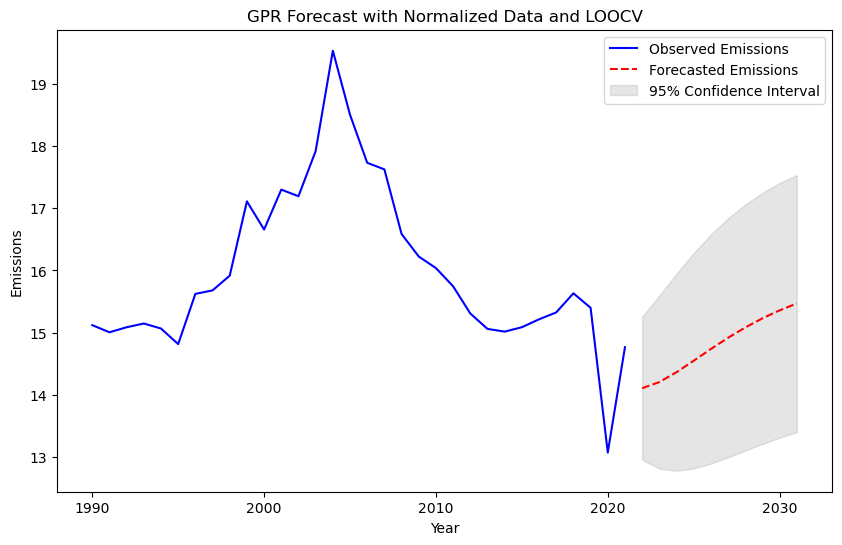

In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, DotProduct, ConstantKernel as C, ExpSineSquared
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Sample data
data = {
    'Year': np.arange(1990, 2022),
    'Emissions': [
        15.120625, 15.005884, 15.086747, 15.146864, 15.066461,
        14.815692, 15.623592, 15.67985, 15.917011, 17.112669,
        16.658678, 17.301097, 17.195188, 17.921412, 19.535977,
        18.506215, 17.733149, 17.626947, 16.587534, 16.224746,
        16.038716, 15.745639, 15.308146, 15.060186, 15.016348,
        15.087477, 15.21436, 15.325243, 15.63322, 15.399656,
        13.071437, 14.766522
    ]
}

# Create DataFrame
df = pd.DataFrame(data)
selected_columns = df[['Year']]  # Ensure this is a DataFrame
y = df['Emissions'].values  # This is a 1D array

# Normalize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Reshape selected_columns to be 2D
X_scaled = scaler_X.fit_transform(selected_columns.values.reshape(-1, 1))
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()

# Define kernels
kernels = [
    C(1.0, (1e-2, 1e2)) * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3)),
    C(1.0, (1e-2, 1e2)) * Matern(length_scale=1.0, length_scale_bounds=(1e-3, 1e3), nu=1.5),
    C(1.0, (1e-2, 1e2)) * RationalQuadratic(length_scale=1.0, alpha=0.1),
    C(1.0, (1e-2, 1e2)) * DotProduct(sigma_0=1.0) + RBF(length_scale=1.0),
    C(1.0, (1e-2, 1e2)) * (RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3)) +
                            ExpSineSquared(length_scale=1.0, periodicity=10))
]



# Initialize Leave-One-Out cross-validator
loo = LeaveOneOut()

# Train GPR models with normalized data using LOOCV
best_score = np.inf  # Initialize best_score to infinity for comparison
for kernel in kernels:
    mse_scores, rmse_scores, mae_scores = [], [], []
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.2)

    # Leave-One-Out Cross Validation
    for train_index, test_index in loo.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y_scaled[train_index], y_scaled[test_index]

        # Fit the model and predict on the test set
        gpr.fit(X_train, y_train)
        y_pred = gpr.predict(X_test)

        # Calculate evaluation metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)

        # Append to lists
        mse_scores.append(mse)
        rmse_scores.append(rmse)
        mae_scores.append(mae)

    # Compute the mean of the scores for each metric
    mean_mse = np.mean(mse_scores)
    mean_rmse = np.mean(rmse_scores)
    mean_mae = np.mean(mae_scores)
    print(f'Kernel: {kernel}, Mean MSE: {mean_mse}, Mean RMSE: {mean_rmse}, Mean MAE: {mean_mae}')

    # Update the best model if current mean_mse is lower
    if mean_mse < best_score:
        best_score = mean_mse
        best_kernel = kernel
        best_model = gpr

# Predict future emissions with normalized data
future_years = np.arange(2022, 2032).reshape(-1, 1)
future_years_scaled = scaler_X.transform(future_years)

# Perform predictions
predictions_scaled, std_scaled = best_model.predict(future_years_scaled, return_std=True)
predictions = scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1))

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(df['Year'], df['Emissions'], 'b-', label='Observed Emissions')
plt.plot(future_years, predictions, 'r--', label='Forecasted Emissions')
plt.fill_between(future_years.ravel(), predictions.ravel() - 1.96 * std_scaled, predictions.ravel() + 1.96 * std_scaled, alpha=0.2, color='gray', label='95% Confidence Interval')
plt.xlabel('Year')
plt.ylabel('Emissions')
plt.legend()
plt.title('GPR Forecast with Normalized Data and LOOCV')
plt.show()


In [12]:
best_model

GaussianProcessRegressor(alpha=0.2,
                         kernel=1**2 * Matern(length_scale=1, nu=1.5),
                         n_restarts_optimizer=10)